<a href="https://colab.research.google.com/github/lazarovps/Data-Science/blob/main/brazilian_houses_to_rent_(aluguel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prevendo valores de aluguel de apartamentos

Dado o amplo mercado imobiliário do país, pensou-se na possibilidade de união desse com Machine Learning, então, esse projeto visa prever os valores de aluguéis de apartamento em algumas regiões no país com base em algumas características desses. Outras aplicações de modelos semelhantes poderia ser para precificar os imóveis para a venda/financiamento.

#Importação de bibliotecas e dos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import drive 
warnings.filterwarnings("ignore")
drive.mount('/content/drive')
%cd /content/drive/My Drive/Python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Python


In [2]:
base = pd.read_csv("houses_to_rent.csv")

In [3]:
base.head(3)

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841


In [4]:
base.shape

(10692, 13)

In [5]:
#Antes de iniciarmos o tratamento e manipulação dos dados, vamos renomear as colunas para facilitar na hora de referenciar
base.columns = ['cidade', 'area','quartos', 'banheiros', 'vagas_garagem','andar','aceita_pet','mobilia','condominio','aluguel','iptu','seguro_incendio','total']

In [6]:
base.head(3)

,cidade,area,quartos,banheiros,vagas_garagem,andar,aceita_pet,mobilia,condominio,aluguel,iptu,seguro_incendio,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841


In [7]:
#Pelo fato de 'total' ser a soma de todas as outras variáveis monetárias (condominio, aluguel, iptu e seguro) ela será descartada
base.drop('total', axis = 1, inplace = True)

#Análise exploratória

In [8]:
base.head(3)

,cidade,area,quartos,banheiros,vagas_garagem,andar,aceita_pet,mobilia,condominio,aluguel,iptu,seguro_incendio
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41


In [9]:
#Reordenando as colunas
base = base.reindex(columns = ['cidade','aceita_pet','mobilia','area','andar','condominio','quartos','banheiros','vagas_garagem','iptu','seguro_incendio','aluguel'])

In [10]:
#Verificando o tipo e se há valores nulos nos dados
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cidade           10692 non-null  object
 1   aceita_pet       10692 non-null  object
 2   mobilia          10692 non-null  object
 3   area             10692 non-null  int64 
 4   andar            10692 non-null  object
 5   condominio       10692 non-null  int64 
 6   quartos          10692 non-null  int64 
 7   banheiros        10692 non-null  int64 
 8   vagas_garagem    10692 non-null  int64 
 9   iptu             10692 non-null  int64 
 10  seguro_incendio  10692 non-null  int64 
 11  aluguel          10692 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1002.5+ KB


In [11]:
#Verificando a estatística descritiva das variáveis numéricas
base.describe().T

,count,mean,std,min,25%,50%,75%,max
area,10692.0,149.217920,537.016942,11.0,56.0,90.0,182.0,46335.0
condominio,10692.0,1174.021698,15592.305248,0.0,170.0,560.0,1237.5,1117000.0
quartos,10692.0,2.506079,1.171266,1.0,2.0,2.0,3.0,13.0
banheiros,10692.0,2.236813,1.407198,1.0,1.0,2.0,3.0,10.0
vagas_garagem,10692.0,1.609147,1.589521,0.0,0.0,1.0,2.0,12.0
iptu,10692.0,366.704358,3107.832321,0.0,38.0,125.0,375.0,313700.0
seguro_incendio,10692.0,53.300879,47.768031,3.0,21.0,36.0,68.0,677.0
aluguel,10692.0,3896.247194,3408.545518,450.0,1530.0,2661.0,5000.0,45000.0


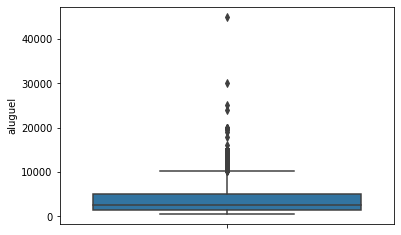

In [12]:
#Verificando a distribuição dos valores de 'aluguel'
sns.boxplot(y = 'aluguel', data = base)

Ao olharmos para a variável alvo em um boxplot, podemos facilmente verificar os valores que são atípicos (outliers), para que o nosso modelo possa aprender corretamente é interessante eliminarmos esses valores discrepantes.

Faremos isso por meio do *Z score*. Seja Z~(0,1), cada observação possuirá um valor z calculado.

Um valor será considerado outlier se |z_calc|> 3  
De outra forma, um valor é outlier se ele estiver há uma distância de mais de 3 desvios padrões da média.

In [13]:
#Importando a biblioteca necessária para o cálculo do Z score
from scipy import stats

In [14]:
#Criamos uma coluna no dataset com o valor Z calculado para cada uma das observações
base['z_score'] = np.abs(stats.zscore(base['aluguel']))

In [15]:
#Verificando os valores outliers
base[base['z_score'] > 3]

,cidade,aceita_pet,mobilia,area,andar,condominio,quartos,banheiros,vagas_garagem,iptu,seguro_incendio,aluguel,z_score
8,São Paulo,acept,furnished,152,3,1000,2,2,1,250,191,15000,3.257774
131,São Paulo,acept,not furnished,900,-,0,4,6,8,4417,226,15000,3.257774
157,São Paulo,acept,furnished,660,12,4800,4,5,5,1750,254,20000,4.724744
176,São Paulo,acept,not furnished,500,-,0,4,5,8,1850,226,15000,3.257774
180,São Paulo,not acept,furnished,384,3,3500,4,6,4,344,191,15000,3.257774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10581,São Paulo,acept,furnished,350,2,5000,4,5,4,0,191,15000,3.257774
10583,São Paulo,not acept,furnished,431,8,6200,3,3,2,1370,191,15000,3.257774
10620,Rio de Janeiro,acept,not furnished,400,-,2000,4,4,2,917,229,15000,3.257774
10633,Rio de Janeiro,acept,not furnished,290,-,0,4,4,0,750,229,15000,3.257774


In [16]:
base['aluguel'].max(), base['z_score'].max()

(45000, 12.059594011822531)

In [17]:
#O maior aluguel da nossa lista é de 45 mil reais e está há 12 desvios padrões da média.

#Eliminando os outliers
base = base[base['z_score']< 3]

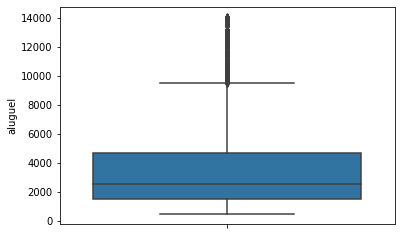

In [18]:
sns.boxplot(y = 'aluguel', data = base)

In [19]:
base['aluguel'].max(), base['z_score'].max()

(14080, 2.987851861976575)

In [20]:
#Agora, nosso maior valor é de "apenas" 14 mil, estando há menos de 3 desvios padrões de distância da média

In [21]:
base.shape

(10436, 13)

In [22]:
#Verificando o shape dos dados, constatamos que eliminamos aproximadamente 250 valores discrepantes

#Explorando a relação entre as outras variáveis com 'aluguel'

Text(0.5, 1.0, 'Distribuição do aluguel por cidade')

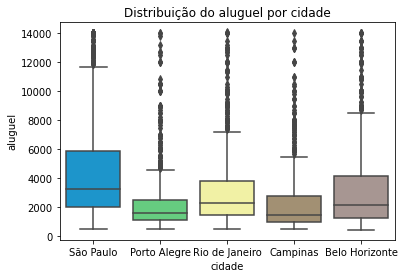

In [23]:
sns.boxplot(x = 'cidade', y = 'aluguel', palette = 'terrain', data = base).set_title("Distribuição do aluguel por cidade")

In [24]:
#Conseguimos perceber uma ordinalidade nas cidades, sendo que os maiores valores do aluguel são em média em São Paulo.

In [25]:
base.aceita_pet.value_counts()

acept        8104
not acept    2332
Name: aceita_pet, dtype: int64

Text(0.5, 1.0, 'Valor médio do aluguel dos apartamentos que aceitam e que não aceitam pets')

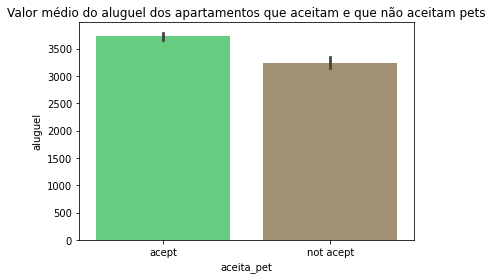

In [26]:
sns.barplot(x = 'aceita_pet', y = 'aluguel', palette = 'terrain', data = base).set_title("Valor médio do aluguel dos apartamentos que aceitam e que não aceitam pets")

Aparentemente, os apartamentos que aceitam pet têm maiores alugueis, para embasar nossa conclusão, podemos realizar um teste t 
como as seguintes hipóteses:

*H0*: µ aceita = µ nao_aceita               
*H1*: µ aceita != µ nao_aceita         
Onde a letra grega µ (mi) representa a média dos aluguéis.

Para a = 0,01 e g.l = 2331, rejeita-se H0 se:

|t_calc| < 2,576 

Importando o pacote necessário e realizando o teste temos:


In [27]:
from scipy.stats import ttest_ind

In [28]:
aceita = base[base['aceita_pet'] == 'acept']
nao_aceita = base[base['aceita_pet'] != 'acept']

In [29]:
aceita.shape, nao_aceita.shape

((8104, 13), (2332, 13))

In [30]:
ttest_ind(aceita['aluguel'],nao_aceita['aluguel'],equal_var= False )

Ttest_indResult(statistic=7.3025437134560685, pvalue=3.3843153778640536e-13)

O T calculado foi de 7,30, então, temos fortes evidências para acreditar que há diferença entre a média dos alugueis dos condomínios que aceitam e os que não aceitam pets.

Agora iremos verificar o aluguel pela variável 'mobilia'


Text(0.5, 1.0, 'Valor médio do aluguel dos apartamentos mobilhados e não mobilhados')

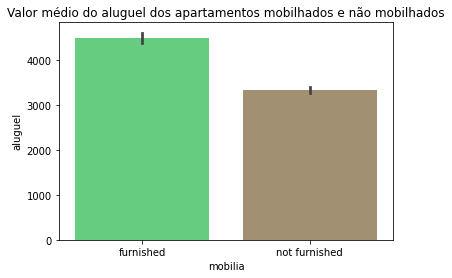

In [31]:
sns.barplot(x = 'mobilia', y = 'aluguel', palette = 'terrain', data = base).set_title("Valor médio do aluguel dos apartamentos mobilhados e não mobilhados")

In [32]:
base.mobilia.value_counts()

not furnished    7925
furnished        2511
Name: mobilia, dtype: int64

Semelhante ao caso anterior, queremos verificar se há diferença nos preços dos apartamentos mobilhados e não mobilhados, como hipóteses temos:

*H0*: µ mobilhado = µ nao_mobilhado               
*H1*: µ mobilhado != µ nao_mobilhado         
Onde a letra grega µ (mi) representa a média dos aluguéis.

Para a = 0,01 e g.l = 2510, rejeita-se H0 se:

|t_calc| < 2,576 

Realizando o teste temos:

In [33]:
mobilhado = base[base['mobilia'] == 'furnished']
nao_mobilhado = base[base['mobilia'] != 'furnished']

In [34]:
mobilhado.shape, nao_mobilhado.shape

((2511, 13), (7925, 13))

In [35]:
ttest_ind(mobilhado['aluguel'],nao_mobilhado['aluguel'],equal_var= False )

Ttest_indResult(statistic=16.91350816888735, pvalue=5.233004238733494e-62)

Como já era esperado, a estatística do teste foi altíssima, nos dando embasamento para acreditar que os apartamentos mobilhados possuem, em média, maiores alugueis.

Dando sequência à análise, olha-se agora para a relação 'area' x 'aluguel'

Text(0.5, 1.0, 'Distribuição aluguel x area')

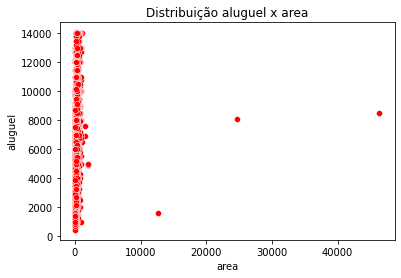

In [36]:
sns.scatterplot(x = 'area', y = 'aluguel', color = 'red', data = base).set_title(("Distribuição aluguel x area"))

Mesmo com a eliminação dos outliers de 'aluguel', algumas observações estão com valores discrepantes em 'area'. Para evitar descartamos mais valores por causa de outliers em variáveis explicativas (não queremos prever seus valores), iremos apenas fazer um filtro rapidamente para conferir a distribuição entre as variáveis.


Plotando o mesmo gráfico mas com valores de 'area' menroes que 10.000, temos: 

Text(0.5, 1.0, 'Distribuição do aluguel x área (ajustado)')

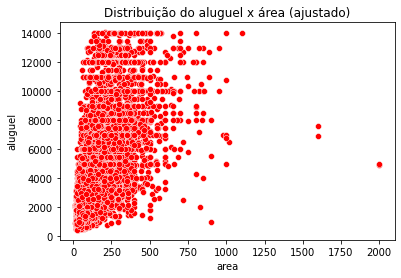

In [37]:
sns.scatterplot(x = 'area', y = 'aluguel', color = 'red', data = base[base['area'] < 10000]).set_title("Distribuição do aluguel x área (ajustado)")

Enfim, percebemos que não há nenhum padrão claro.



Text(0.5, 1.0, 'Distribuição aluguel x andar')

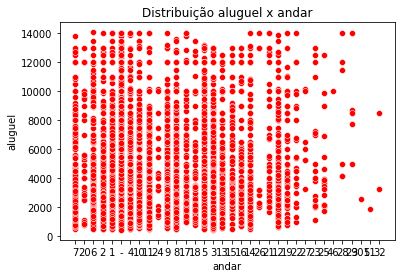

In [38]:
sns.scatterplot(x = 'andar', y = 'aluguel', color = 'red', data = base).set_title('Distribuição aluguel x andar')

Não há padrão claro em o valor do aluguel e o andar do apartamento.

Text(0.5, 1.0, 'Distribuição aluguel x taxa de condomínio')

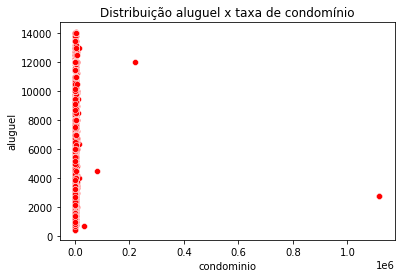

In [39]:
sns.scatterplot(x = 'condominio', y = 'aluguel', color = 'red', data = base).set_title('Distribuição aluguel x taxa de condomínio')

Mesmo caso da variável 'andar', nesse caso iremos filtrar para valores menores que 30.000

Text(0.5, 1.0, 'Distribuição aluguel x taxa de condomínio (ajustado)')

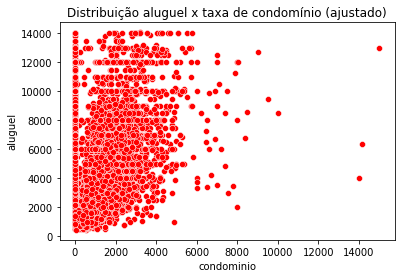

In [40]:
sns.scatterplot(x = 'condominio', y = 'aluguel', color = 'red', data = base[base['condominio']<30000]).set_title('Distribuição aluguel x taxa de condomínio (ajustado)')

Após o filtro ainda não conseguimos ver nenhum padrão definido na relação 'aluguel' x 'condominio'.

Text(0.5, 1.0, 'Distribuição do aluguel x quartos')

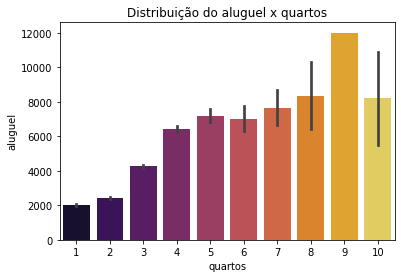

In [41]:
sns.barplot(x = 'quartos', y = 'aluguel', palette = 'inferno', data = base).set_title("Distribuição do aluguel x quartos")

Conseguimos perceber que há uma relação entre a quantidade de quartos e os valores de aluguel, para verificar a intensidade dessa relação, é interessante calcular a correlação entre as variáveis, ela vai nos retornar um valor entre -1 e 1 que indicará se as variáveis variam na mesma direção ou não e a intensidade desse movimento. Correlação negativa indica que quando uma variável aumenta a outra tende a diminuir.

Para a intensidade, usualmente define-se o seguinte:

Se a correlação (desconsiderando o sinal)  for < 0.3 considera-se uma correlação fraca
Se a correlação (desconsiderando o sinal) estiver entre 0.3 e 0.7 considera-se uma correlação normal
Se a correlação (desconsiderando o sinal) for > 0.7 considera-se uma correlação forte


In [42]:
from scipy.stats import pearsonr

In [43]:
pearsonr(base['quartos'],base['aluguel'])

(0.5382505589820639, 0.0)

O resultado do comando anterior retorna a correlação entre as variáveis, que nesse caso foi normal e positiva, e a probabilidade de se obter essa correlação aleatoriamente, nesse caso, temos fortes evidencias para acreditar nessa relação entre as variáveis.

Text(0.5, 1.0, 'Distribuição do aluguel x banheiros')

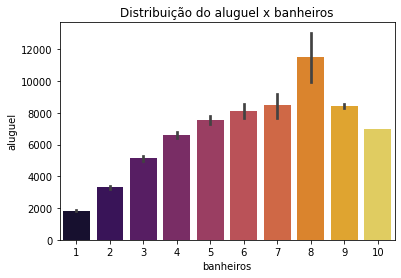

In [44]:
sns.barplot(x = 'banheiros', y = 'aluguel', palette = 'inferno', data = base).set_title("Distribuição do aluguel x banheiros")

Semelhante à análise anterior, há claramente um padrão entre a quantidade de banheiros e o valor do aluguel. Verificando a correlação entre as variáveis:

In [45]:
pearsonr(base['banheiros'],base['aluguel'])

(0.6649468923575896, 0.0)

A correlação entre as variáveis é um pouco mais forte que antes e a chance desse valor se dá ao acaso é 0 também, corroborando o resultado observado.

Text(0.5, 1.0, 'Distribuição do aluguel x vagas de garagem')

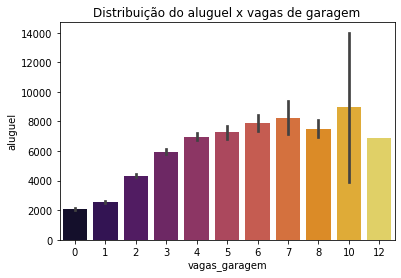

In [46]:
sns.barplot(x = 'vagas_garagem', y = 'aluguel', palette = 'inferno', data = base).set_title("Distribuição do aluguel x vagas de garagem")

In [47]:
pearsonr(base['vagas_garagem'],base['aluguel'])

(0.5753296739158724, 0.0)

A mesma relação pode ser observada com as vagas de garagem. 

Verificando a relação 'iptu' x 'aluguel'

Text(0.5, 1.0, 'Distribuição do aluguel x iptu')

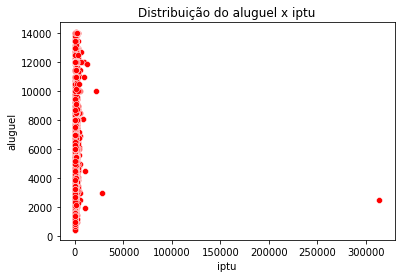

In [48]:
sns.scatterplot(x = 'iptu', y = 'aluguel', color='red', data = base).set_title("Distribuição do aluguel x iptu")

In [49]:
#Mesmo caso que já vimos, faremos um filtro para valores de iptu menores que 300.000

Text(0.5, 1.0, 'Distribuição do aluguel x iptu (ajustado)')

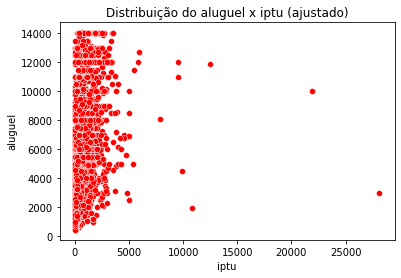

In [50]:
sns.scatterplot(x = 'iptu', y = 'aluguel', color = 'red', data = base[base['iptu']<300000]).set_title("Distribuição do aluguel x iptu (ajustado)")

Também não encontramos padrões definidos para esse relação.

Text(0.5, 1.0, 'Distribuição do aluguel x seguro de incêndio')

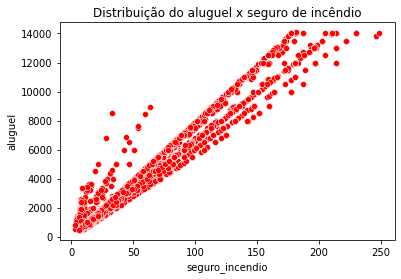

In [51]:
sns.scatterplot(x = 'seguro_incendio', y = 'aluguel', color = 'red', data = base).set_title("Distribuição do aluguel x seguro de incêndio")

Percebe-se claramente que o aluguel e o valor do seguro de incêndio possuem correlação forte e positiva. Calculando a correlação formalmente temos:

In [52]:
pearsonr(base['seguro_incendio'],base['aluguel'])

(0.9864915295608025, 0.0)

Percebemos que 'seguro_incendio' possui uma correlação muito forte com o valor do aluguel.

Para visualizarmos melhor todas essas correlações podemos plotar uma matriz de correlação das variáveis.
Pelo a característica comumativa da matriz de correlação, podemos plotar apenas o triângulo inferior, já que os valores são espelhados.

Antes disso, iremos remover a coluna 'z_score' que criamos no começo.


Text(0.5, 1.0, 'Distribuição do aluguel x quartos')

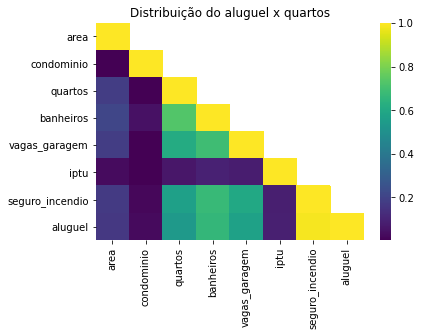

In [53]:
base.drop('z_score', axis =1 , inplace = True)
mask_corr = np.triu(base.corr(), k = 1)
sns.heatmap(base.corr(), mask = mask_corr,  cmap = 'viridis').set_title("Distribuição do aluguel x quartos")

Após a análise exploratória, podemos definir as variáveis que serão utilizadas pelos algoritmos. O critério será de manter apenas as que aparentaram possuir algum tipo de relação com a variável alvo.
As variáveis que não encontramos nenhum padrão claro e por isso iremos eliminar do modelo preditivo são:


* *area*
* *andar*
* *condominio*
* *iptu*

Podemos então já dividir em X (variáveis explicativas) e y (variável alvo)


In [54]:
X = base.drop(['area','andar','condominio','iptu','aluguel'], axis = 1)
y = base['aluguel']

#Manipulação das variáveis

In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10436 entries, 0 to 10691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cidade           10436 non-null  object
 1   aceita_pet       10436 non-null  object
 2   mobilia          10436 non-null  object
 3   quartos          10436 non-null  int64 
 4   banheiros        10436 non-null  int64 
 5   vagas_garagem    10436 non-null  int64 
 6   seguro_incendio  10436 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 972.2+ KB


Para as variáveis 'aceita_pet' e 'mobilia', podemos apenas converter 'acept' e 'furnished', respectivamente, em 1, assim o algoritmo consegue levá-las em conta

In [56]:
X.aceita_pet.value_counts()

acept        8104
not acept    2332
Name: aceita_pet, dtype: int64

In [57]:
X['aceita_pet'] = X['aceita_pet'].replace({'acept':1,'not acept':0})
X.aceita_pet.value_counts()

1    8104
0    2332
Name: aceita_pet, dtype: int64

In [58]:
X.mobilia.value_counts()

not furnished    7925
furnished        2511
Name: mobilia, dtype: int64

In [59]:
X['mobilia'] = X['mobilia'].replace({'furnished':1, 'not furnished':0})
X.mobilia.value_counts()

0    7925
1    2511
Name: mobilia, dtype: int64

Para a variável 'cidade', além de transformar seu rótulos, devemos transformá-las em diversas colunas, onde cada coluna será binária

In [60]:
X.cidade.value_counts()

São Paulo         5702
Rio de Janeiro    1478
Belo Horizonte    1220
Porto Alegre      1186
Campinas           850
Name: cidade, dtype: int64

In [61]:
X['cidade'] = X['cidade'].replace({'São Paulo': 'sp', 'Rio de Janeiro':'rj','Belo Horizonte':'bh','Porto Alegre':'pa','Campinas':'cam'})
X = pd.get_dummies(X)

In [62]:
X.head(3)

,aceita_pet,mobilia,quartos,banheiros,vagas_garagem,seguro_incendio,cidade_bh,cidade_cam,cidade_pa,cidade_rj,cidade_sp
0,1,1,2,1,1,42,0,0,0,0,1
1,1,0,4,4,0,63,0,0,0,0,1
2,1,0,1,1,1,41,0,0,1,0,0


Nesse caso, cada coluna representará uma cidade e quando o apartamento for de uma dessas, a coluna relativa terá o valor 1.

Por fim, podemos dividir os dados em dados de treino e dados de teste, a porcentagem utilizada para cada um dos conjuntos será de 75% e 25%, respectivamente.

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10436 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   aceita_pet       10436 non-null  int64
 1   mobilia          10436 non-null  int64
 2   quartos          10436 non-null  int64
 3   banheiros        10436 non-null  int64
 4   vagas_garagem    10436 non-null  int64
 5   seguro_incendio  10436 non-null  int64
 6   cidade_bh        10436 non-null  uint8
 7   cidade_cam       10436 non-null  uint8
 8   cidade_pa        10436 non-null  uint8
 9   cidade_rj        10436 non-null  uint8
 10  cidade_sp        10436 non-null  uint8
dtypes: int64(6), uint8(5)
memory usage: 941.7 KB


#Implementação dos modelos

In [64]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test, y_train, y_test = tts(X,y, random_state = 10, test_size = 0.25)

In [65]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7827, 11), (2609, 11), (7827,), (2609,))

Para avaliarmos o desempenho de um modelo de Machine Learning, devemos olhar para alguma(s) métrica(s), as que foram escolhidas para esse trabalho foram:

R² score;
Mean Squared Error;
Mean Absolute Error;
Mean Percentage Error;

In [66]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [67]:
#Criando a função para o MAPE (Mean Absolute Percentage Error)
def mape(real,predict):
  real, predict = np.array(real), np.array(predict)
  return np.mean(np.abs((real - predict)/real)*100)

Após a divisão do conjunto de dados, podemos enfim instanciar e rodar alguns algoritmos.


Modelo 1 - Regressão Linear

In [68]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [69]:
#Fitando e prevendo valores com o modelo 1
reg.fit(X_train,y_train)
y_predict = reg.predict(X_test)

In [70]:
#Métricas para o modelo 1
r2 = round(r2_score(y_test,y_predict),4)
MSE = round(mean_squared_error(y_test,y_predict),4)
MAE = round(mean_absolute_error(y_test,y_predict),4)
MAPE = round(mape(y_test,y_predict),4)

Modelo 2 - Regressão Linear com variáveis polinomiais

In [71]:
from sklearn.preprocessing import PolynomialFeatures
polynomial = PolynomialFeatures(degree = 2)

In [72]:
#Fitando e prevendo valores com o modelo 2
X_train_poly = polynomial.fit_transform(X_train)
X_test_poly = polynomial.fit_transform(X_test)
reg.fit(X_train_poly,y_train)
y_predict_poly = reg.predict(X_test_poly)

In [73]:
#Métricas para o modelo 2
r2_poly = round(r2_score(y_test,y_predict_poly),4)
MSE_poly = round(mean_squared_error(y_test,y_predict_poly),2)
MAE_poly = round(mean_absolute_error(y_test,y_predict_poly),2)
MAPE_poly = round(mape(y_test,y_predict_poly),4)

Modelo 3 - Regressão linear (com variáveis padronizadas)

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [75]:
#Fitando e prevendo valores com o modelo 3
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
reg.fit(X_train_scaled,y_train)
y_predict_scaled = reg.predict(X_test_scaled)

In [76]:
#Métricas para o modelo 3
r2_scaled = round(r2_score(y_test,y_predict_scaled),4)
MSE_scaled = round(mean_squared_error(y_test,y_predict_scaled),2)
MAE_scaled = round(mean_absolute_error(y_test,y_predict_scaled),2)
MAPE_scaled = round(mape(y_test,y_predict_scaled),4)

Modelo 4 - Random Forest Regressor (com variáveis padronizadas)

In [77]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()

In [78]:
#Fitando e prevendo valores com o modelo 4
rfr.fit(X_train_scaled,y_train)
y_predict_rfr = rfr.predict(X_test_scaled)

In [79]:
#Métricas para o modelo 4
r2_rfr = round(r2_score(y_test,y_predict_rfr),4)
MSE_rfr = round(mean_squared_error(y_test,y_predict_rfr),2)
MAE_rfr = round(mean_absolute_error(y_test,y_predict_rfr),2)
MAPE_rfr = round(mape(y_test,y_predict_rfr),4)

#Resultados

In [80]:
print("Regressão Linear:\n\nR2: {}\nMSE: {}\nMAE: {}\nMAPE: {} %\n".format(r2,MSE,MAE, MAPE))
print("Regressão Linear (Polinomial Features):\n\nR2: {}\nMSE: {}\nMAE: {}\nMAPE: {} %\n".format(r2_poly,MSE_poly,MAE_poly, MAPE_poly))
print("Regressão Linear(padronizado):\n\nR2: {}\nMSE: {}\nMAE: {}\nMAPE: {} %\n".format(r2_scaled,MSE_scaled,MAE_scaled, MAPE_scaled))
print("Random Forest Regressor (padronizado):\n\nR2: {}\nMSE: {}\nMAE: {}\nMAPE: {} %\n".format(r2_rfr,MSE_rfr,MAE_rfr, MAPE_rfr))

Regressão Linear:

R2: 0.9757
MSE: 191631.2242
MAE: 283.8128
MAPE: 9.237 %

Regressão Linear (Polinomial Features):

R2: 0.9819
MSE: 142618.5
MAE: 209.15
MAPE: 5.6647 %

Regressão Linear(padronizado):

R2: 0.9756
MSE: 191893.24
MAE: 284.57
MAPE: 9.2859 %

Random Forest Regressor (padronizado):

R2: 0.9866
MSE: 105629.03
MAE: 154.64
MAPE: 4.9706 %



#Conclusão

Todos os algoritmos tiveram ótimo desempenho, mas o que se sobressaiu foi o Random Forest Regressor, que se distanciou apenas 5% do real valor do aluguel.

Esse é um exemplo de algoritmo que poderia ser utilizado para a precificação de imóveis, definição de aluguel e até para algum tipo de financiamento imobiliário.